In [276]:
# to display images inline
%matplotlib inline

import copy
import cv2
import pycocotools  
import sys
import matplotlib.cbook as cbook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import ast
from tqdm.notebook import tqdm
import csv
import random
import hashlib
import numpy as np
import os
from operator import itemgetter 
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from os import listdir
from os.path import isfile, join

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [277]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [278]:
scraped_images = [img for img in listdir(DIR_PATH+'scraped_photos_final') if img != '.DS_Store']
# scraped_images = [img for img in listdir(DIR_PATH+'newspaper-navigator-master/beyond_words_data/images') if img != '.DS_Store']

In [279]:
with open(DIR_PATH + "Master_degree/source_annotations/train_80_percent.json") as jsonFile:
    coco_metadata_train = json.load(jsonFile)
    jsonFile.close()
    
with open(DIR_PATH + "Master_degree/source_annotations/val_20_percent.json") as jsonFile:
    coco_metadata_test = json.load(jsonFile)
    jsonFile.close()

In [280]:
# train
len(coco_metadata_train['images']), len(coco_metadata_train['annotations'])

(2846, 38478)

In [281]:
# test
len(coco_metadata_test['images']), len(coco_metadata_test['annotations'])

(712, 9931)

In [282]:
# combined 
len(scraped_images), len(coco_metadata_train['images'])+len(coco_metadata_test['images']), len(coco_metadata_train['annotations'])+len(coco_metadata_test['annotations'])

(3559, 3558, 48409)

In [283]:
# one image is missing in source train-test (provided by newspaper-navigator), so I have to find it
train_img_names = []
for i in range(len(coco_metadata_train['images'])):
    train_img_names.append(coco_metadata_train['images'][i]['file_name'])
    
test_img_names = []
for i in range(len(coco_metadata_test['images'])):
    test_img_names.append(coco_metadata_test['images'][i]['file_name'])

In [284]:
[x for x in scraped_images if x not in (train_img_names + test_img_names)]

['728.jpg']

In [285]:
# okey, I found it, now let's remove it from our list
scraped_images.remove('728.jpg')

In [286]:
# now lenghts are equal
len(scraped_images), (len(coco_metadata_train['images'])+len(coco_metadata_test['images']))

(3558, 3558)

In [287]:
# coco format structure overview
list(coco_metadata_train.keys())

['info', 'licenses', 'categories', 'images', 'annotations']

In [288]:
coco_metadata_train['info']

{'description': 'Beyond Words Dataset (verified)',
 'URL': 'http://beyondwords.labs.loc.gov/#/',
 'version': '1.0',
 'year': 2020,
 'contributor': 'LC Labs',
 'date_created': '03/17/2020'}

In [289]:
coco_metadata_train['licenses'][0]

{'url': 'https://creativecommons.org/publicdomain/zero/1.0/',
 'id': 1,
 'name': 'CC0 1.0'}

In [290]:
coco_metadata_train['categories']

[{'id': 0, 'name': 'Photograph', 'supercategory': 'Content'},
 {'id': 1, 'name': 'Illustration', 'supercategory': 'Content'},
 {'id': 2, 'name': 'Map', 'supercategory': 'Content'},
 {'id': 3, 'name': 'Comics/Cartoon', 'supercategory': 'Content'},
 {'id': 4, 'name': 'Editorial Cartoon', 'supercategory': 'Content'},
 {'id': 5, 'name': 'Headline', 'supercategory': 'Content'},
 {'id': 6, 'name': 'Advertisement', 'supercategory': 'Content'}]

In [291]:
coco_metadata_train['images'][0]

{'license': 1,
 'file_name': '1.jpg',
 'url': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/kyu_dubnium_ver01/data/sn86069496/00280763251/1918082801/0282.jpg',
 'height': 1330,
 'width': 912,
 'date_captured': '12/1/2019',
 'id': 1}

In [292]:
coco_metadata_train['annotations'][0]

{'id': 3988,
 'bw_id': '5d49ec38ebaf180001001c9d',
 'image_id': 1,
 'category_id': 0,
 'bbox': [612, 92, 271, 338],
 'iscrowd': 0,
 'area': 91598}

In [293]:
def rescale_annotations(coco_metadata):
    for i in tqdm(range(len(coco_metadata['images']))):
        iterable_path_i = coco_metadata['images'][i]
        file_name = iterable_path_i['file_name']
        scraped_photo_width, scraped_photo_height = get_image_size.get_image_size(
            DIR_PATH+'scraped_photos_final/'+file_name
        )
        scaler_height = scraped_photo_height/iterable_path_i['height']
        scaler_width = scraped_photo_width/iterable_path_i['width']

        iterable_path_i['height'], iterable_path_i['width'] = scraped_photo_height, scraped_photo_width

        for ii in range(len(coco_metadata['annotations'])):
            if int(coco_metadata['annotations'][ii]['image_id']) == int(iterable_path_i['id']):
                iterable_path_ii = coco_metadata['annotations'][ii]
                # bbox in coco should be [x,y,width,height]
                iterable_path_ii['bbox'][0], iterable_path_ii['bbox'][2] = int(iterable_path_ii['bbox'][0]*scaler_width), int(iterable_path_ii['bbox'][2]*scaler_width)
                iterable_path_ii['bbox'][1], iterable_path_ii['bbox'][3] = int(iterable_path_ii['bbox'][1]*scaler_height), int(iterable_path_ii['bbox'][3]*scaler_height)
                
                iterable_path_ii['area'] = iterable_path_ii['bbox'][2]*iterable_path_ii['bbox'][3]
                
    return coco_metadata

In [294]:
# I scraped better resolution data (than are provided in source repository of newspaper-navigator) 
# so i need to change height and width and also annotation bbox'es
coco_metadata_train = rescale_annotations(coco_metadata_train)
coco_metadata_test = rescale_annotations(coco_metadata_test)

In [295]:
coco_metadata_train['images'][0]

{'license': 1,
 'file_name': '1.jpg',
 'url': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/kyu_dubnium_ver01/data/sn86069496/00280763251/1918082801/0282.jpg',
 'height': 7985,
 'width': 5472,
 'date_captured': '12/1/2019',
 'id': 1}

In [296]:
coco_metadata_train['annotations'][0]

{'id': 3988,
 'bw_id': '5d49ec38ebaf180001001c9d',
 'image_id': 1,
 'category_id': 0,
 'bbox': [3672, 552, 1626, 2029],
 'iscrowd': 0,
 'area': 3299154}

In [297]:
def reduce_original_coco_json(coco_metadata):
    del coco_metadata['info']
    del coco_metadata['licenses']
    
    for i in range(len(coco_metadata['categories'])):
        del coco_metadata['categories'][i]['supercategory']
    
    for ii in range(len(coco_metadata['images'])):
        del coco_metadata['images'][ii]['license']
        del coco_metadata['images'][ii]['url']
        del coco_metadata['images'][ii]['date_captured']
    
    for iii in range(len(coco_metadata['annotations'])):
        del coco_metadata['annotations'][iii]['id']
        del coco_metadata['annotations'][iii]['bw_id']
        
    return coco_metadata

In [298]:
# I don't neet such amount of information stored in my jsons so I need to reduce them
coco_metadata_train = reduce_original_coco_json(coco_metadata_train)
coco_metadata_test = reduce_original_coco_json(coco_metadata_test)

In [299]:
def show_random_img_with_all_annotations(coco_metadata, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(coco_metadata['images']))
        file_name = coco_metadata['images'][random_img]['file_name']
        print(coco_metadata['images'][random_img]['file_name'])

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        for i in range(len(coco_metadata['annotations'])):
            if int(coco_metadata['annotations'][i]['image_id']) == int(file_name.split('.')[0]):
                x0 = coco_metadata['annotations'][i]['bbox'][0]
                y0 = coco_metadata['annotations'][i]['bbox'][1]
                width = coco_metadata['annotations'][i]['bbox'][2]
                height = coco_metadata['annotations'][i]['bbox'][3]
                cat_id = int(coco_metadata['annotations'][i]['category_id'])
                rect = matplotlib.patches.Rectangle(
                    (x0, y0), 
                    width, 
                    height, 
                    linewidth=1, 
                    edgecolor=matplotlib_colours_list[cat_id], 
                    facecolor='none'
                )
                
                ax.add_patch(rect)           
                ax.text(
                    x0, 
                    y0, 
                    coco_metadata_train['categories'][cat_id]['name'], 
                    fontsize=8,
                    backgroundcolor='black',
                    color=matplotlib_colours_list[cat_id]
                )

        plt.show()

1323.jpg


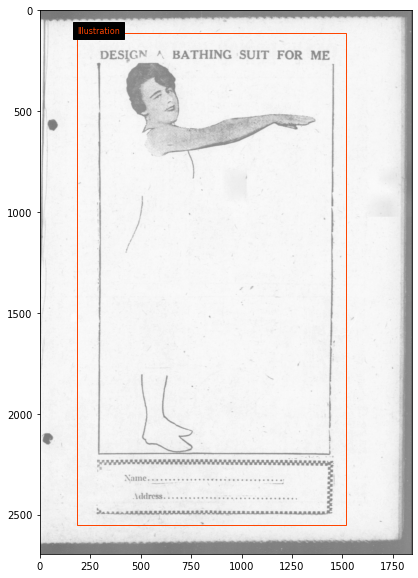

2150.jpg


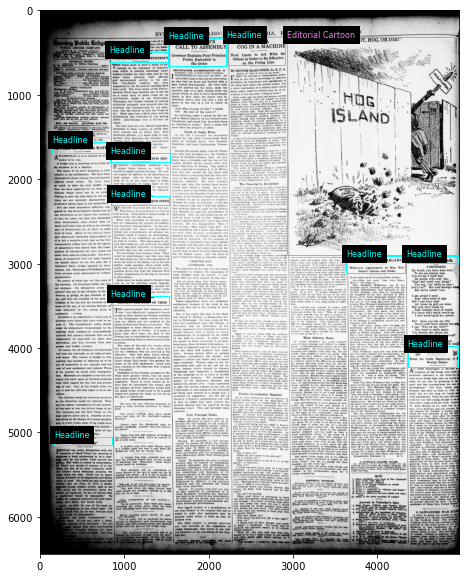

957.jpg


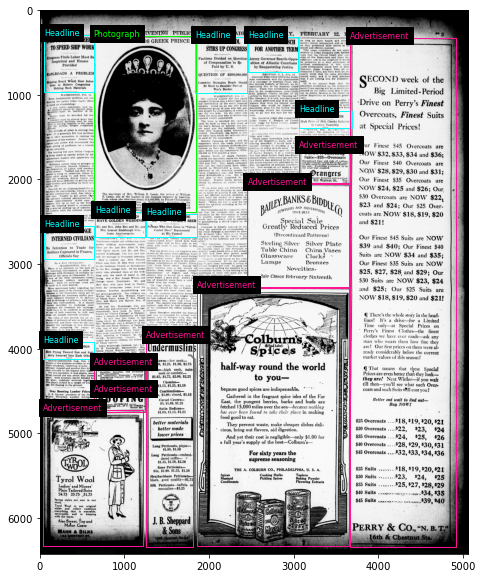

209.jpg


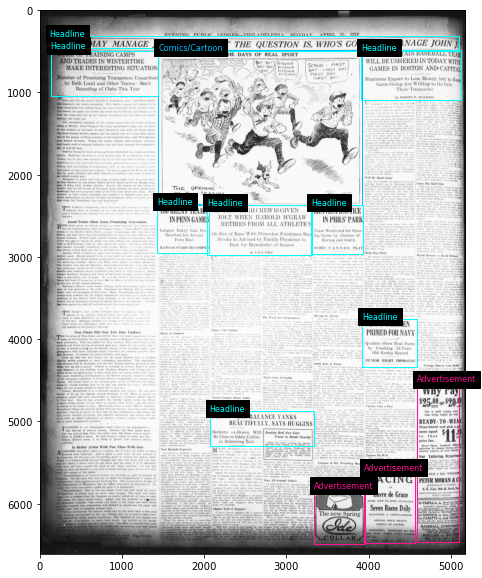

615.jpg


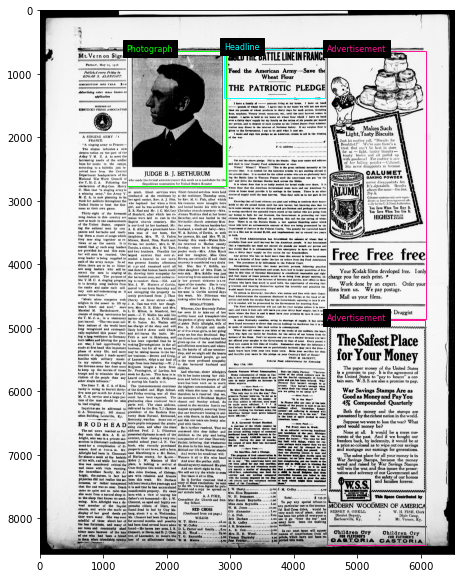

In [300]:
# some random images with annotations
show_random_img_with_all_annotations(
    coco_metadata_train,
    DIR_PATH+'scraped_photos_final/',
#     DIR_PATH+'newspaper-navigator-master/beyond_words_data/images/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [301]:
# train val split by md5 hash library
set_names = [
    coco_metadata_train['images'][i]['file_name'].split('.')[0] for i in range(len(coco_metadata_train['images']))
]

In [302]:
def calcMD5Hash(name, split):
    return int(hashlib.md5(str(name).encode('Utf-8')).digest()[-1]) <= split * 256

In [303]:
train_val_hash_list = list(pd.Series(set_names).apply(lambda x: calcMD5Hash(x, 0.08)))

In [304]:
train_names, val_names = [], []

for i in range(len(train_val_hash_list)):
    if train_val_hash_list[i] == True:
        val_names.append(set_names[i])
    elif train_val_hash_list[i] == False:
        train_names.append(set_names[i])

In [305]:
len(train_names), len(val_names)

(2630, 216)

In [306]:
coco_metadata_val = copy.deepcopy(coco_metadata_train)

In [307]:
def remove_coco_elem_if_in_list(coco_file, key_name, list_with_names_to_remove, id_key):
    indexes_to_remove = []
    for i in range(len(coco_file[key_name])):
        if str(coco_file[key_name][i][id_key]) in list_with_names_to_remove:
            indexes_to_remove.append(i)
    
    for index in sorted(indexes_to_remove, reverse=True):
        del coco_file[key_name][int(index)]
    
    return coco_file

In [308]:
coco_metadata_val = remove_coco_elem_if_in_list(coco_metadata_val, 'images', train_names, 'id')
coco_metadata_val = remove_coco_elem_if_in_list(coco_metadata_val, 'annotations', train_names, 'image_id')

In [309]:
# val - shape
len(coco_metadata_val['images']), len(coco_metadata_val['annotations'])

(216, 2879)

In [310]:
coco_metadata_train = remove_coco_elem_if_in_list(coco_metadata_train, 'images', val_names, 'id')
coco_metadata_train = remove_coco_elem_if_in_list(coco_metadata_train, 'annotations', val_names, 'image_id')

In [311]:
# train - new shape
len(coco_metadata_train['images']), len(coco_metadata_train['annotations'])

(2630, 35599)

In [312]:
coco_metadata_train['images'][0]

{'file_name': '1.jpg', 'height': 7985, 'width': 5472, 'id': 1}

In [313]:
# checking if every image has annotations 
def is_annotation(coco_file):
    image_ids_1 = []
    image_ids_2 = []
    
    for i in range(len(coco_file['images'])):
        image_ids_1.append(coco_file['images'][i]['id'])
    
    for i in range(len(coco_file['annotations'])):
        image_ids_2.append(coco_file['annotations'][i]['image_id'])
        
    missing_list = list(set(image_ids_1) - set(image_ids_2))
    
    return missing_list

In [314]:
# train
missing_list_train = is_annotation(coco_metadata_train)

# val
missing_list_val = is_annotation(coco_metadata_val)

# test
missing_list_test = is_annotation(coco_metadata_test)

In [315]:
missing_list_train, missing_list_val, missing_list_test

([], [3050], [])

In [316]:
def remove_missed_images(coco_file, missing_images_id_list):
    len_before = len(coco_file['images'])
    to_remove = []
    for i in range(len(coco_file['images'])):
        if coco_file['images'][i]['id'] in missing_images_id_list:
            to_remove.append(i)
    
    for index in to_remove:
        del coco_file['images'][index]
        
    print(f"length before = {len_before}, length after = {len(coco_file['images'])}")
    
    return coco_file

In [317]:
# train
coco_metadata_train = remove_missed_images(coco_metadata_train, missing_list_train)

# val
coco_metadata_val = remove_missed_images(coco_metadata_val, missing_list_val)

# test
coco_metadata_test = remove_missed_images(coco_metadata_test, missing_list_test)

length before = 2630, length after = 2630
length before = 216, length after = 215
length before = 712, length after = 712


In [318]:
def print_alert(reason, img_number, img_name, critical=False):
    if critical == True:
        print(f'Value error, current annotation will be missed:\nIteration number: {img_number} | reason: {reason} | image name: {img_name}\n')
    else:
        print(f'Value correction alert:\nIteration number: {img_number} | reason: {reason} | image name: {img_name}\n')

In [319]:
# transformer to gonito (evaluation platform) shape
def gonito_transformer(coco_file, path_to_photos_dir):
    in_list = []
    expected_list = []
    for i in tqdm(range(len(coco_file['images']))):
        img_string = ' '
        img_name = coco_file['images'][i]['file_name']
        in_list.append(img_name)
        for ii in range(len(coco_file['annotations'])):
            if int(coco_file['images'][i]['id']) == int(coco_file['annotations'][ii]['image_id']):
                img_width, img_height = get_image_size.get_image_size(
                    path_to_photos_dir + coco_file['images'][i]['file_name']
                )
                cat = coco_file['annotations'][ii]['category_id']
                x0 = coco_file['annotations'][ii]['bbox'][0]
                y0 = coco_file['annotations'][ii]['bbox'][1]
                x1 = x0 + coco_file['annotations'][ii]['bbox'][2]
                y1 = y0 + coco_file['annotations'][ii]['bbox'][3]
                # correction of bad located pixel coordinates
                if x0 < 0:
                    print_alert('x0 < 0', i, img_name)
                    x0 = 1
                if y0 < 0:
                    print_alert('y0 < 0', i, img_name)
                    y0 = 1
                if x0 > img_width:
                    print_alert('x0 > img_width', i, img_name, critical=1)
                    continue
                if y0 > img_height:
                    print_alert('y0 > img_height', i, img_name, critical=1)
                    continue
                if x1 < 0:
                    print_alert('x1 < 0', i, img_name, critical=1)
                    continue
                if y1 < 0:
                    print_alert('y1 < 0', i, img_name, critical=1)
                    continue
                if x1 > img_width:
                    print_alert('x1 > img_width', i, img_name)
                    x1 = img_width-1
                if y1 > img_height:
                    y1 = img_height-1
                    print_alert('y1 > img_height', i, img_name)
                img_string = img_string + f"{cat}/{x0},{y0},{x1},{y1}/{30} "
        
        img_string = img_string.strip()
        if img_string == '':
            del in_list[-1]
        else:
            expected_list.append(img_string)
                       
    return in_list, expected_list

In [320]:
train_in, train_expected = gonito_transformer(coco_metadata_train, DIR_PATH + 'scraped_photos_final/')
val_in, val_expected = gonito_transformer(coco_metadata_val, DIR_PATH + 'scraped_photos_final/')
test_in, test_expected = gonito_transformer(coco_metadata_test, DIR_PATH + 'scraped_photos_final/')

Value correction alert:
Iteration number: 14 | reason: x0 < 0 | image name: 19.jpg

Value correction alert:
Iteration number: 26 | reason: x1 > img_width | image name: 33.jpg

Value correction alert:
Iteration number: 148 | reason: x1 > img_width | image name: 194.jpg

Value correction alert:
Iteration number: 217 | reason: y0 < 0 | image name: 279.jpg

Value correction alert:
Iteration number: 248 | reason: x1 > img_width | image name: 325.jpg

Value correction alert:
Iteration number: 397 | reason: x1 > img_width | image name: 549.jpg

Value correction alert:
Iteration number: 660 | reason: x0 < 0 | image name: 905.jpg

Value correction alert:
Iteration number: 712 | reason: x1 > img_width | image name: 978.jpg

Value correction alert:
Iteration number: 712 | reason: x1 > img_width | image name: 978.jpg

Value correction alert:
Iteration number: 712 | reason: y1 > img_height | image name: 978.jpg

Value correction alert:
Iteration number: 957 | reason: x1 > img_width | image name: 13

Value correction alert:
Iteration number: 82 | reason: x1 > img_width | image name: 1216.jpg

Value correction alert:
Iteration number: 154 | reason: x1 > img_width | image name: 2402.jpg




Value correction alert:
Iteration number: 10 | reason: x1 > img_width | image name: 65.jpg

Value correction alert:
Iteration number: 114 | reason: x0 < 0 | image name: 555.jpg

Value correction alert:
Iteration number: 114 | reason: y0 < 0 | image name: 555.jpg

Value correction alert:
Iteration number: 243 | reason: y1 > img_height | image name: 1225.jpg

Value correction alert:
Iteration number: 287 | reason: x1 > img_width | image name: 1468.jpg

Value correction alert:
Iteration number: 287 | reason: x1 > img_width | image name: 1468.jpg

Value correction alert:
Iteration number: 492 | reason: x1 > img_width | image name: 2480.jpg




In [321]:
# save list to tsv file
def save_list_to_tsv_file(path, output_list):
    with open(path, 'w', newline='') as f_output: 
        tsv_output = csv.writer(f_output, delimiter='\n')
        tsv_output.writerow(output_list)

In [322]:
# # save formated coco dict to json
# def dump_json(path, dict_to_save):
#     jsonString = json.dumps(dict_to_save, indent=4)
#     jsonFile = open(path, "w")
#     jsonFile.write(jsonString)
#     jsonFile.close()

In [324]:
# train:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/expected.tsv', train_expected)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/in.tsv', train_in)

# dump_json(DIR_PATH + 'Master_degree/preprocessed_annotations/coco_train.json', coco_metadata_train)

# val:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/expected.tsv', val_expected)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/in.tsv', val_in)

# dump_json(DIR_PATH + 'Master_degree/preprocessed_annotations/coco_val.json', coco_metadata_val)

# test:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/in.tsv', test_in)

# dump_json(DIR_PATH + 'Master_degree/preprocessed_annotations/coco_test.json', coco_metadata_test)

In [ ]:
# save only if you are on branch dont-peek in Master_gonito 
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/expected.tsv', test_expected)